# Майнор по Анализу Данных, Группа ИАД-2
## Домашнее задание №3 
## Деревья решений, случайный лес

<hr\>
**Общая информация**

**Срок сдачи:** 3 июня 2017, 23:59 <br\>

При отправлении ДЗ на почту `hse.minor.dm+2@gmail.com` указывайте фамилию в названии файла, а тему письма оформляйте в следующем виде:<br\>
** [ИАД-2] *{Фамилия}* *{Имя}* ДЗ*{Номер}* **<br\>

Сопровождайте ваш код изображеними, комментариями и выводами. <br\>
Иммейте ввиду, что на некоторые задачи нет единственного верного и полного ответа. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше.

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [518]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Classify leaf with random forest

Задание основано на Kaggle соревновании [Leaf Classification](https://www.kaggle.com/c/leaf-classification/).

Помните [Iris](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)? Данные, с которыми вам предстоит работать в этом задании концептуально похожи на ирисы.

Дана информация о 990 листьях, каждый из которых был сорван с одного из 99 видов растений.</br> 
Необходимо построить модель, которая могла бы определить, к какому растению относится каждый лист.

## Табличные данные

Загрузите файл `table_data.csv`.

В нем вы можете найти
* id - идентификатор листика
* species - столбец с названием растения (класс)
* margin, shape, texture - некоторые признаки листьев

In [519]:
DATA_DIR = os.path.join('data')
IMG_DIR = os.path.join(DATA_DIR, 'images')

In [520]:
filepath = os.path.join(DATA_DIR, 'table_data.csv')
table_data = pd.read_csv(filepath)

In [521]:
table_data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


## Создание контрольного и обучающих множеств (1 балл)

* Задайте `random_seed`, который необходимо будет использовать при **всех** случаях использования генератора случайных чисел
* С помощью LabelEncoder закодируйте столбец `species` из исходных данных - вы должны получить одномерный numpy массив с метками классов от 0 до 98
* В переменную `X` запишите значения признаков margin, shape, texture - вы должны получить многомерный numpy массив

In [522]:
from sklearn.preprocessing import LabelEncoder

In [523]:
random_seed = 123 # задаем seed для всех моделей

In [524]:
le = LabelEncoder() # кодируем столбец 'species'
y = le.fit_transform(table_data['species'])

In [525]:
X = table_data.drop(table_data.columns[0:2], axis = 1) # создание матрицы признаков
X = np.array(X.as_matrix()) # привели матрицу к ndarray

* Случайным образом разбейте данные на обучающую и контрольную выборку, причем так, чтобы в контрольной выборке содержалось по 2 объекта каждого класса.
* Сохраните индексы объектов обучающего и контрольного множеств в переменные train_idx и test_idx

#### Hint
[Это](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) может помочь.

In [526]:
from sklearn.model_selection import StratifiedShuffleSplit

In [527]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = random_seed)

for train_index, test_index in sss.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    
    train_ind, test_ind = train_index, test_index

In [528]:
tb = table_data.as_matrix()
train_idx, test_idx = [], []

for i in train_ind:
    train_idx.append(tb[i][0])

for j in test_ind:
    test_idx.append(tb[j][0])

## Сравнение RF, DT и Bagging'а (2 балла)

На кросс-валидации по обучающей выборке сравните качество и скорость
1. Обычного дерева решений 
2. Bagging'a над деревьями решений с 10, 50, 100, 200 и 300 деревьями
3. Cлучайного леса с 10, 50, 100, 200 и 300 деревьями


* Изобразите полученные результаты на одном графике
* Используйте `StratifiedKFold` с 4 фолдами для оценки качества
* Мера качества - `accuracy`

In [529]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

In [530]:
skf = StratifiedKFold(n_splits = 4, random_state = random_seed, shuffle = True)

In [531]:
DTc = DecisionTreeClassifier(random_state = random_seed)

In [533]:
DTc_tscores = []
DTc_time = []
for tr_idx, val_idx in skf.split(X_train, y_train):
    a = time.clock()
    DTc.fit(X_train[tr_idx], y_train[tr_idx])
    DTc_predict = DTc.predict(X_train[val_idx])
    b = time.clock() - a
    DTc_tscores.append(accuracy_score(DTc_predict, y_train[val_idx]))
    DTc_time.append(b)
DTc_mean = np.mean(DTc_time)
DTc_mean

0.20953824999969584

In [534]:
nTreeEstimators = [10, 50, 100, 200, 300]
BGc_scores = []
BGc_t_time = []
BGc_time = []
for trees in nTreeEstimators:
    BGc_tscores = []
    for tr_idx, val_idx in skf.split(X_train, y_train):
        BGc = BaggingClassifier(random_state = random_seed, n_estimators = trees)
        a = time.clock()
        BGc.fit(X_train[tr_idx], y_train[tr_idx])
        BGc_predict = BGc.predict(X_train[val_idx])
        b = time.clock() - a
        BGc_tscores.append(accuracy_score(BGc_predict, y_train[val_idx]))
        BGc_t_time.append(b)
    BGc_scores.append(np.mean(BGc_tscores))
    BGc_time.append(np.mean(BGc_t_time))
print(np.mean(BGc_scores))

0.907070707071


In [535]:
RFc_scores = []
RFc_t_time = []
RFc_time = []
for trees in nTreeEstimators:
    RFc_tscores = []
    for tr_idx, val_idx in skf.split(X_train, y_train):
        RFc = RandomForestClassifier(random_state = random_seed, n_estimators = trees)
        a = time.clock()
        RFc.fit(X_train[tr_idx], y_train[tr_idx])
        RFc_predict = RFc.predict(X_train[val_idx])
        b = time.clock() - a
        RFc_tscores.append(accuracy_score(RFc_predict, y_train[val_idx]))
        RFc_t_time.append(b)
    RFc_scores.append(np.mean(RFc_tscores))
    RFc_time.append(np.mean(RFc_t_time))
print(np.mean(RFc_scores))

0.945202020202


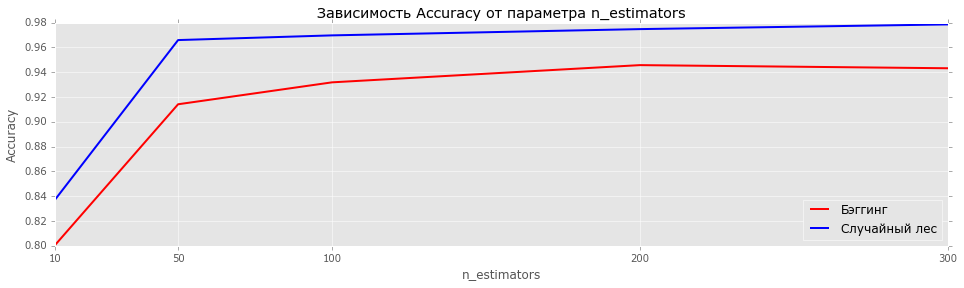

In [536]:
import matplotlib.pyplot as plt
plt.figure(figsize=[16, 4])
plt.xticks(nTreeEstimators)
plt.title('Зависимость Accuracy от параметра n_estimators')
plt.plot(nTreeEstimators, BGc_scores, color='red', lw=2)
plt.plot(nTreeEstimators, RFc_scores, color='blue', lw=2)
plt.legend(["Бэггинг", "Случайный лес"], loc = 4)
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.grid(True)
plt.show()

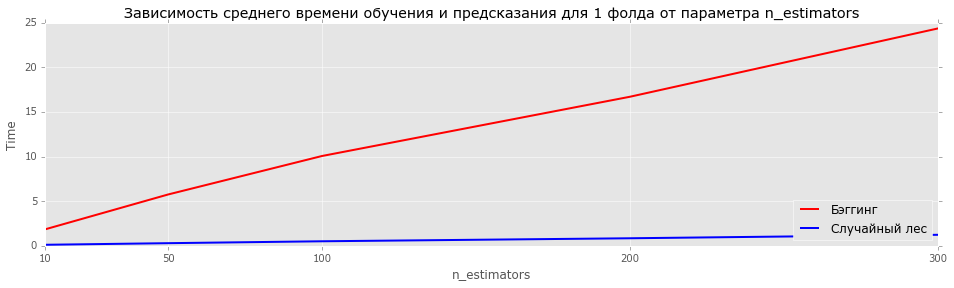

In [537]:
plt.figure(1, figsize=[16, 4])
plt.xticks(nTreeEstimators)
plt.title('Зависимость среднего времени обучения и предсказания для 1 фолда от параметра n_estimators')
plt.plot(nTreeEstimators, BGc_time, color='red', lw=2)
plt.plot(nTreeEstimators, RFc_time, color='blue', lw=2)
plt.legend(["Бэггинг", "Случайный лес"], loc = 4)
plt.ylabel('Time')
plt.xlabel('n_estimators')
plt.grid(True)
plt.show()

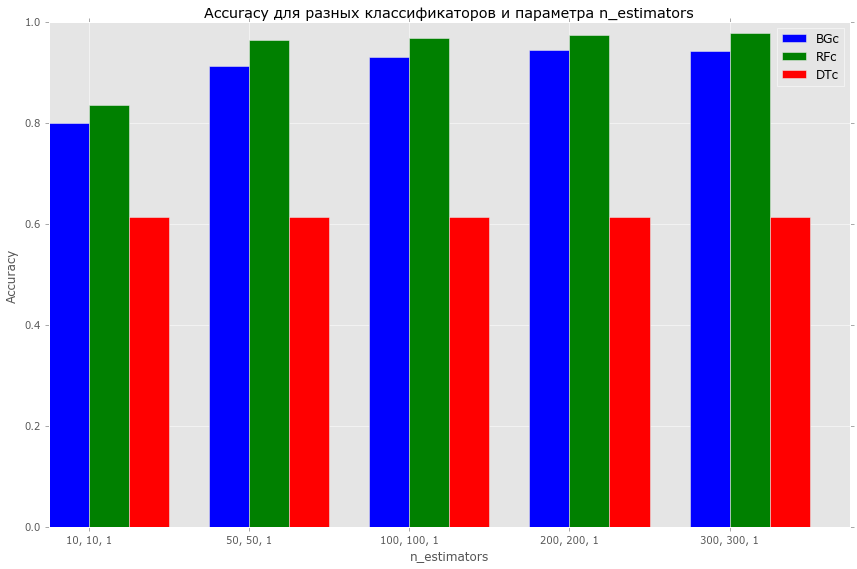

In [539]:
n_groups = 5
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
DTc_pltscores = [np.mean(DTc_tscores), np.mean(DTc_tscores), np.mean(DTc_tscores), np.mean(DTc_tscores), np.mean(DTc_tscores)]

rects1 = plt.bar(index, BGc_scores, bar_width,
                 alpha=opacity,
                 color='b',
                 label=('BGc'))
 
rects2 = plt.bar(index + bar_width, RFc_scores, bar_width,
                 alpha=opacity,
                 color='g',
                 label=('RFc'))

rects2 = plt.bar(index + bar_width + bar_width, DTc_pltscores, bar_width,
                 alpha=opacity,
                 color='r',
                 label=('DTc'))
 
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy для разных классификаторов и параметра n_estimators')
plt.xticks(index + bar_width, ('10, 10, 1', '50, 50, 1', '100, 100, 1', '200, 200, 1', '300, 300, 1'))
plt.legend()
plt.tight_layout()
plt.show()

Бэггинг имеет результат по accuracy чуть ниже, чем случайный лес. Так же случайный лес быстрее обучается и делает предсказания. Решающее дерево показало худший результат по доле правильных классификаций.

# Изображения листьев

В папке `images` лежат 1584 изображения различного размера, названные в соответствии с id из файла `table_data.csv`.

In [540]:
filepath = os.path.join(IMG_DIR, '33.jpg')
img = plt.imread(filepath)

In [541]:
img.shape

(357, 700)

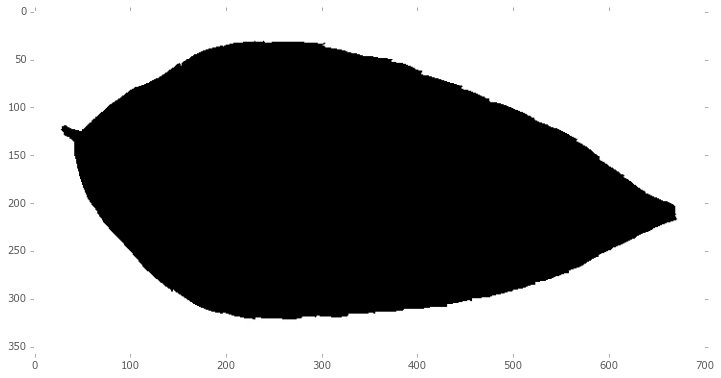

In [542]:
plt.imshow(img, cmap='Greys')
plt.grid(None)

## Загрузка изображений (1 балла)

Необходимо
1. "Стандартизировать" размер изображений - сделать его одинаковым для всех
2. Отобрать изображения тех листьев, которые представлены в `table_data`

Пункт 1. можно сделать двумя способами:
* C помощью функции scipy.misc.imresize (неидеальный вариант)
* Найти максимальные длинну и ширину полотна и перенести исходные картинки в центр (кажется, что так лучше)

В результате этого задания вы должны получить получить массив изображений IMG_train и IMG_test для обучающей и контрольной выборки.

In [543]:
from scipy.misc import imresize

In [544]:
img_resized = imresize(img, (100, 100))

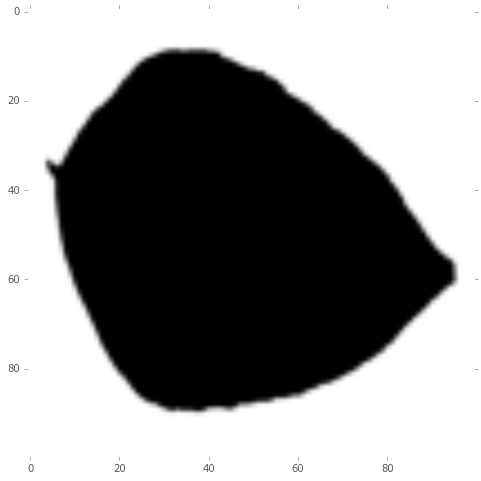

In [545]:
plt.imshow(img_resized, cmap='Greys')
plt.grid(None)

In [548]:
IMG_test, IMG_train = [], []

for i in test_idx:
    filepath = os.path.join(IMG_DIR, str(i) + '.jpg')
    IMG_temp = plt.imread(filepath)
    IMG_resized = imresize(IMG_temp, (100, 100))
    IMG_test.append(np.array(IMG_resized.reshape(1, 10000)[0]))
    
for j in train_idx:
    filepath = os.path.join(IMG_DIR, str(j) + '.jpg')
    IMG_temp = plt.imread(filepath)
    IMG_resized = imresize(IMG_temp, (100, 100))
    IMG_train.append(np.array(IMG_resized.reshape(1, 10000)[0]))

In [553]:
IMG_train = np.asarray(IMG_train).astype(int)
IMG_test = np.asarray(IMG_test).astype(int)

Привел к 100 на 100, так как при больших размерностях долго работал TSNE.

## TSNE (2 балла)

* Переформатируйте IMG_train и IMG_test к виду "матрица объект-признак" (команда reshape)
* На данных в X_train и IMG_train (по отдельности) изобразите результат применения T-SNE со следующими настройками: `n_components=2, perplexity=[5,10,20,30,50], method='exact', n_iter=5000, learning_rate=500`. 
* У вас должно получится 10 `scatter-plot` графиков с точками, расскашенными в цвет своего класса (для наглядности в `plt.scatter` укажите `cmap=plt.cm.Paired`)
* В каком случае (X_train или IMG_train) кластеры выделяются лучше? Как вы думаете, почему?


In [554]:
from sklearn.manifold import TSNE

In [557]:
model1 = TSNE(n_components=2, perplexity=5, method='exact', n_iter=5000, learning_rate=500, random_state = random_seed)
m1 = model1.fit_transform(X_train)

model2 = TSNE(n_components=2, perplexity=10, method='exact', n_iter=5000, learning_rate=500, random_state = random_seed)
m2 = model2.fit_transform(X_train) 

model3 = TSNE(n_components=2, perplexity=20, method='exact', n_iter=5000, learning_rate=500, random_state = random_seed)
m3 = model3.fit_transform(X_train) 

model4 = TSNE(n_components=2, perplexity=30, method='exact', n_iter=5000, learning_rate=500, random_state = random_seed)
m4 = model4.fit_transform(X_train) 

model5 = TSNE(n_components=2, perplexity=50, method='exact', n_iter=5000, learning_rate=500, random_state = random_seed)
m5 = model5.fit_transform(X_train) 

In [561]:
model11 = TSNE(n_components=2, perplexity=5, method='exact', n_iter=5000, learning_rate=500, random_state = random_seed)
m11 = model1.fit_transform(IMG_train)

model22 = TSNE(n_components=2, perplexity=10, method='exact', n_iter=5000, learning_rate=500, random_state = random_seed)
m22 = model2.fit_transform(IMG_train) 

model33 = TSNE(n_components=2, perplexity=20, method='exact', n_iter=5000, learning_rate=500, random_state = random_seed)
m33 = model3.fit_transform(IMG_train) 

model44 = TSNE(n_components=2, perplexity=30, method='exact', n_iter=5000, learning_rate=500, random_state = random_seed)
m44 = model4.fit_transform(IMG_train) 

model55 = TSNE(n_components=2, perplexity=50, method='exact', n_iter=5000, learning_rate=500, random_state = random_seed)
m55 = model5.fit_transform(IMG_train) 

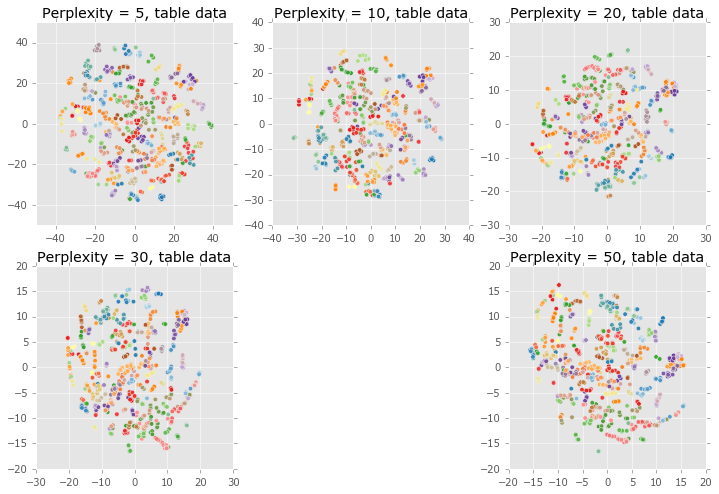

In [562]:
plt.subplot(231)
plt.title('Perplexity = 5, table data')
plt.scatter(m1[:, 0], m1[:, 1], c = y_train, cmap=plt.cm.Paired)
plt.subplot(232)
plt.title('Perplexity = 10, table data')
plt.scatter(m2[:, 0], m2[:, 1], c = y_train, cmap=plt.cm.Paired)
plt.subplot(233)
plt.title('Perplexity = 20, table data')
plt.scatter(m3[:, 0], m3[:, 1], c = y_train, cmap=plt.cm.Paired)
plt.subplot(234)
plt.title('Perplexity = 30, table data')
plt.scatter(m4[:, 0], m4[:, 1], c = y_train, cmap=plt.cm.Paired)
plt.subplot(236)
plt.title('Perplexity = 50, table data')
plt.scatter(m5[:, 0], m5[:, 1], c = y_train, cmap=plt.cm.Paired)

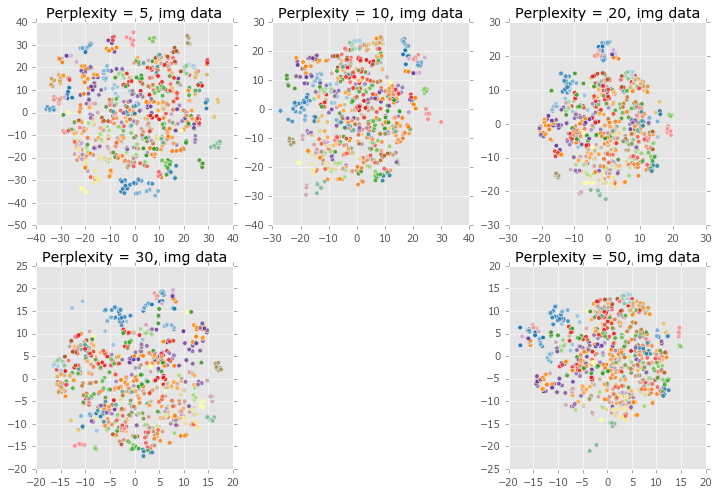

In [563]:
plt.subplot(231)
plt.title('Perplexity = 5, img data')
plt.scatter(m11[:, 0], m11[:, 1], c = y_train, cmap=plt.cm.Paired)
plt.subplot(232)
plt.title('Perplexity = 10, img data')
plt.scatter(m22[:, 0], m22[:, 1], c = y_train, cmap=plt.cm.Paired)
plt.subplot(233)
plt.title('Perplexity = 20, img data')
plt.scatter(m33[:, 0], m33[:, 1], c = y_train, cmap=plt.cm.Paired)
plt.subplot(234)
plt.title('Perplexity = 30, img data')
plt.scatter(m44[:, 0], m44[:, 1], c = y_train, cmap=plt.cm.Paired)
plt.subplot(236)
plt.title('Perplexity = 50, img data')
plt.scatter(m55[:, 0], m55[:, 1], c = y_train, cmap=plt.cm.Paired)

По табличным данным кластеры выделяются более явно. На мой взгляд, T-SNE на бинарных признаках работает не очень хорошо.

## PCA (1 балл)

* Используйте метод главных компонент, чтобы перейти к пространству меньшей размерности. Подберите количество компонент так, чтобы доля объясненной дисперсии составляла 60%
* Используя результаты МГК на кросс-валидации сравните качество
    1. Обычного дерева решений 
    2. Bagging'a над деревьями решений с 10, 50, 100, 200 и 300 деревьями
    3. Cлучайного леса с 10, 50, 100, 200 и 300 деревьями
    
#### Hint
Составьте [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) из PCA и предиктивной модели

In [564]:
PCA_ratio = []
for i in range(1, 15):
    pca = PCA(n_components=i, random_state = random_seed)
    pca.fit(IMG_train)
    PCA_ratio.append(sum(pca.explained_variance_ratio_))

In [565]:
PCA_ratio

[0.16771274750237153,
 0.27790275472399378,
 0.35579381628009105,
 0.41765848843826597,
 0.45715043575796999,
 0.49107514494125676,
 0.51704752517312424,
 0.53945032993099928,
 0.55766089977577638,
 0.57343502728765161,
 0.58783312828452305,
 0.6012996127327227,
 0.61306136072367057,
 0.62438616170249406]

Выберем модель с 12 компонентами, доля объясненной дисперсии составляла 60,12996%

In [566]:
pca_opt = PCA(n_components=12, random_state = random_seed)
pcaIMG_train = pca_opt.fit_transform(IMG_train)

DTc_imscores = []
for tr_idx, val_idx in skf.split(pcaIMG_train, y_train):
    DTc.fit(pcaIMG_train[tr_idx], y_train[tr_idx])
    DTc_predict = DTc.predict(pcaIMG_train[val_idx])
    DTc_imscores.append(accuracy_score(DTc_predict, y_train[val_idx]))
print(np.mean(DTc_imscores))

0.304292929293


In [567]:
BGc_imscores = []

for trees in nTreeEstimators:
    BGc_imtscores = []
    for tr_idx, val_idx in skf.split(pcaIMG_train, y_train):
        BGc = BaggingClassifier(random_state = random_seed, n_estimators = trees)
        BGc.fit(pcaIMG_train[tr_idx], y_train[tr_idx])
        BGc_predict = BGc.predict(pcaIMG_train[val_idx])
        BGc_imtscores.append(accuracy_score(BGc_predict, y_train[val_idx]))
    BGc_imscores.append(np.mean(BGc_imtscores))
print(np.mean(BGc_imscores))

0.459848484848


In [568]:
RFc_imscores = []

for trees in nTreeEstimators:
    RFc_imtscores = []
    for tr_idx, val_idx in skf.split(pcaIMG_train, y_train):
        RFc = RandomForestClassifier(random_state = random_seed, n_estimators = trees)
        RFc.fit(pcaIMG_train[tr_idx], y_train[tr_idx])
        RFc_predict = RFc.predict(pcaIMG_train[val_idx])
        RFc_imtscores.append(accuracy_score(RFc_predict, y_train[val_idx]))
    RFc_imscores.append(np.mean(RFc_imtscores))
print(np.mean(RFc_imscores))

0.47702020202


In [569]:
print(BGc_imscores)
print(RFc_imscores)

[0.39646464646464646, 0.46843434343434343, 0.47979797979797978, 0.47474747474747475, 0.47979797979797983]
[0.39520202020202022, 0.48989898989898994, 0.49873737373737381, 0.5025252525252526, 0.49873737373737376]


Лучше себя на валидационной выборке проявил случайный лес. DTc опять хуже всех.

# Подбор гиперпараметров модели на табличных данных (2 балла)

С помощью `GridSearchCV` или `RandomizedSearchCV` подберите параметры для случайного леса

* Используйте `StratifiedKFold` на 4х фолдах
* Мера качества - `accuracy`

In [570]:
from sklearn import grid_search

In [571]:
classifier = RandomForestClassifier(random_state = random_seed)

parameters_grid = {"n_estimators": [10, 50, 75, 100, 150, 200, 250, 300],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

grid_cv = grid_search.GridSearchCV(classifier, parameters_grid, cv = 4)

In [572]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bootstrap': [True, False], 'n_estimators': [10, 50, 75, 100, 150, 200, 250, 300], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [573]:
grid_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

# Проверка на контрольной выборке (1 балл)

* Примените оптимальную модель на контрольной выборке
* Для нескольких случаев, где была допущена ошибка, выведите истинное изображение листа и одно из изображений листа предсказанного класса

In [574]:
accuracy_score(grid_cv.predict(X_test), y_test)

0.95959595959595956

In [578]:
com = 0
for i in (grid_cv.predict(X_test)):
    if i != y_test[com]:
        print(i, y_test[com])
    com += 1

10 49
79 81
31 84
68 86
13 48
39 40
92 73
92 68


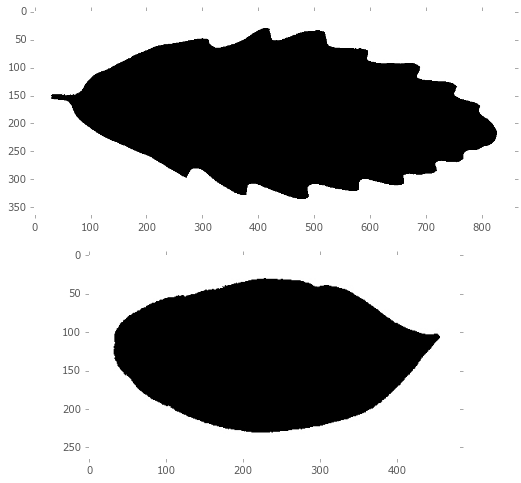

In [579]:
plt.subplot(211)
filepath = os.path.join(IMG_DIR, '10.jpg')
img = plt.imread(filepath)
plt.imshow(img, cmap='Greys')
plt.grid(None)
plt.subplot(212)
filepath = os.path.join(IMG_DIR, '49.jpg')
img = plt.imread(filepath)
plt.imshow(img.T, cmap='Greys')
plt.grid(None)

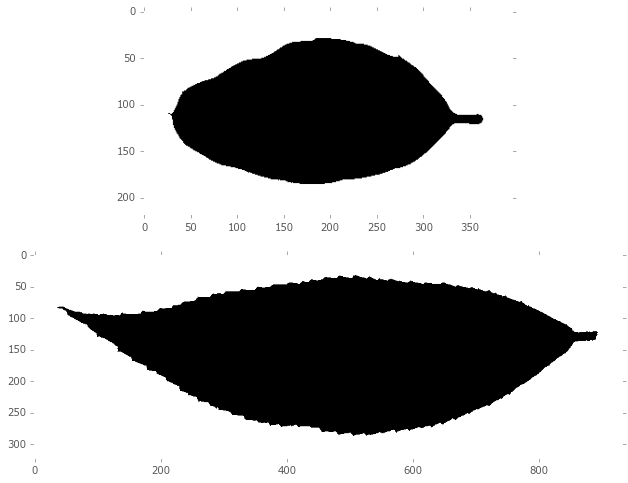

In [580]:
plt.subplot(211)
filepath = os.path.join(IMG_DIR, '92.jpg')
img = plt.imread(filepath)
plt.imshow(img.T, cmap='Greys')
plt.grid(None)
plt.subplot(212)
filepath = os.path.join(IMG_DIR, '73.jpg')
img = plt.imread(filepath)
plt.imshow(img, cmap='Greys')
plt.grid(None)

Как можно заметить, изображения листьев действительно сильно отличаются, наш классификатор имеет изьян. Для вида с id = 92 он ошибся два раза из двух

# Подбор гиперпараметров модели на объединенных данных (2 балла) **

За это задание можно получить 2 дополнительных балла, но сделать его надо безукоризненно =)

Сейчас мы попробуем использовать данные с изображений и табличные данные, которые затем пойдут на вход случайному лесу. Далее надо будет подобрать оптимальные гиперпараметры случайного леса с помощью кросс-валидации

## Объединяем данные

* Составьте матрицу A_train (A_test) как результаты конкатенации матриц X_train и IMG_train (X_test и IMG_test)

In [108]:
# Your Code Here

## Составим  Pipeline

Наш Pipeline условно изображен на рисунке ниже:

<center><img src='scheme.png'></center>


Из объединенных данных в матрице `А` 
1. Выбираются столбцы, которые относятся к изображению и передаются в `PCA`
2. Исходные табличные данные отделяются от всех остальных, но остаются без изменений
3. Результаты пунктов 1 и 2 объединяются
4. И передаются на вход в случайный лес

В результате в переменную model вы должны записать весь Pipeline из шагов 1-4

#### Hints
* Для того, чтобы выбирать столбцы из матрицы `А` можно использовать `FunctionTransformer` (см. пример ниже)
* Для того, чтобы объединять результаты преобразований можно использовать [`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html)

In [109]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

In [110]:
def select_col_idx(X, col_idx=[1]):
    return X[:, col_idx]

In [111]:
trans = FunctionTransformer(select_col_idx, kw_args={'col_idx': [2,3]})

In [112]:
trans.fit_transform(A_train)

array([[ 0.007812,  0.044922],
       [ 0.054688,  0.005859],
       [ 0.039062,  0.046875],
       ..., 
       [ 0.033203,  0.003906],
       [ 0.033203,  0.001953],
       [ 0.03125 ,  0.023438]])

In [141]:
# Your Code Here

## Проверка на контрольной выборке

* Примените оптимальную модель на контрольной выборке
* Сравните качество с моделью на табличных данных

In [ ]:
# Your Code Here